In [1]:
from mnist.loader import MNIST
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import scipy.io
from ipywidgets import interact
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score

d:\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
def lire_alpha_digit(digits, chars):
    """
    Takes as input alpha_digits and an array 'chars' containing the letters or integers to select from the alpha_digits
    """
    indexes = []
    for chr in chars:
        # check if positive integer
        if (chr.isdigit() and int(chr)<10 and int(chr)>0):
            indexes.append(int(chr))
        # check if letter
        elif(chr.isalpha() and len(chr)==1):
            indexes.append(ord(chr.lower()) - 87)
    return digits[indexes, :]

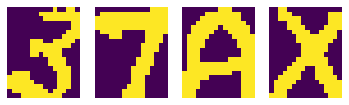

In [3]:
digits = scipy.io.loadmat('binaryalphadigs.mat')['dat']

selected_digits = lire_alpha_digit(digits, ['3', '7', 'A', '-5', 'cb', 'X']) # -5 and 'cb' won't be taken into consideration

fig, axs = plt.subplots(1, selected_digits.shape[0])
for char in range(selected_digits.shape[0]):
    axs[char].axis('off')
    axs[char].imshow(selected_digits[char][7])

A file named 'MNIST' in the same directory should contain the training and testing files extracted, and renamed by replacing the '.' to a '-' <br>
(ex: t10k-images.idx3-ubyte -> t10k-images-idx3-ubyte)

In [4]:
mndata = MNIST('MNIST')
X_train, y_train = mndata.load_training()
X_test, y_test = mndata.load_testing()

X_train = np.array(X_train)
X_train = X_train.reshape(X_train.shape[0], 28, 28)
y_train = np.array(y_train)

X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], 28, 28)
y_test = np.array(y_test)

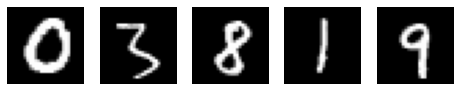

In [5]:
randoms = np.random.randint(0, X_train.shape[0], 5)

fig, axs = plt.subplots(1, randoms.shape[0], figsize=(8,8))
for char, ind in enumerate(randoms):
    axs[char].axis('off')
    axs[char].imshow(X_train[ind], cmap='gray')

In [6]:
def black_white(X, threshold = 125):
    """
    Convert grayscale images of input X to black-and-white images based on given threshold.
    """
    XX = np.empty_like(X)
    XX[X< threshold] = 0
    XX[X>=threshold] = 1
    XX = XX.reshape(*XX.shape, 1) 
    return XX

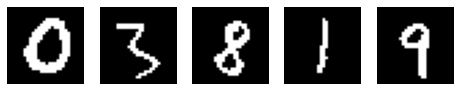

In [7]:
#Testing black_white function
X_train_new = black_white(X_train)

fig, axs = plt.subplots(1, randoms.shape[0], figsize=(8,8))
for char, ind in enumerate(randoms):
    axs[char].axis('off')
    axs[char].imshow(X_train_new[ind], cmap='gray')

In [8]:
def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1/(1+np.exp(-x))

class RBM:
    def __init__(self, in_shape, out_shape, W=None, a=None, b=None, var=0.1):
        assert in_shape != 0 and out_shape != 0
        self.in_shape = in_shape
        self.out_shape = out_shape
        
        self.a = a if a is not None else np.zeros(in_shape)
        self.b = b if b is not None else np.zeros(out_shape)
        self.W = W if W is not None else np.random.normal(0, var, (in_shape, out_shape))
        assert self.W.shape == (in_shape, out_shape) and (self.a).shape[0] == in_shape and (self.b).shape[0] == out_shape
        return
    
    def entree_sortie_RBM(self, X_input):
        prod = np.dot(X_input, self.W) + self.b
        assert prod.shape == (X_input.shape[0], self.out_shape), f"prod shape {prod.shape} != (X_input.shape[0], self.out_shape) {(X_input.shape[0], self.out_shape)}"
        sig = sigmoid(prod)
        return sig, np.random.binomial(1, sig, prod.shape) # Sampling from p(h|x)
    
    def sortie_entree_RBM(self, X_output):
        prod = np.dot(X_output, self.W.T) + self.a
        assert prod.shape == (X_output.shape[0], self.in_shape)
        sig = sigmoid(prod)
        return sig, np.random.binomial(1, sig, prod.shape)  # Samplign from p(x|h)
    
    def train_RBM(self, X_input, epochs=10, learning_rate=0.01, batch_size=1, vis = False):
        errors = []
        for i in range(epochs):
            for bat in range(0, X_input.shape[0], batch_size):
                v_0 = X_input[bat:min(bat + batch_size, X_input.shape[0])]
                curr_bsize = v_0.shape[0]
                h_0p, h_0d = self.entree_sortie_RBM(v_0)
                v_1p, v_1d = self.sortie_entree_RBM(h_0d)
                h_1p, h_1d = self.entree_sortie_RBM(v_1d)
                self.W = self.W + learning_rate * ((np.tensordot(v_0, h_0p, axes=((0),(0))) - np.tensordot(v_1p, h_1p, axes=((0),(0)))))
                self.a = self.a + learning_rate * (np.sum(v_0 - v_1p, 0))
                self.b = self.b + learning_rate * (np.sum(h_0p - h_1p, 0))
            err = mse(v_0, v_1d)
            errors.append(err)
            if(vis):
                print(f"Epoch {i} mse:{err}")
        return errors, self
    
    
    def generer_image_RBM(self, n_iter_gibbs, n_images, vis=True):
        outputs = []
        for i in range(n_images):
            v_0 = np.random.binomial(1, np.random.rand(1, self.in_shape))
            v_0d = v_0.copy()
            for iter in range(n_iter_gibbs):
                h_0p, h_0d = self.entree_sortie_RBM(v_0d)
                v_0p, v_0d = self.sortie_entree_RBM(h_0d)
            outputs.append(v_0d.reshape(20, 16))
            if vis:
                plt.figure()
                plt.imshow(outputs[-1], cmap='gray')
                plt.title("Generated image")
                plt.show()
        return np.array(outputs)

            

In [9]:
testing_rbm = RBM(8, 4)
print("RBM shape:", testing_rbm.W.shape)

# Testing entree_sortie_RBM
in_try = np.random.randint(low=0, high=2, size = (6,8))
print("\nInput shape:", in_try.shape)
print("After Entree_sortie:", testing_rbm.entree_sortie_RBM(in_try)[1].shape)

# Testing sortie_entree_RBM
out_try = np.random.randint(low=0, high=255, size = (13,4))
print("\nInput shape to hidden layer:", out_try.shape)
print("After Sortie_Entree", testing_rbm.sortie_entree_RBM(out_try)[1].shape)


RBM shape: (8, 4)

Input shape: (6, 8)
After Entree_sortie: (6, 4)

Input shape to hidden layer: (13, 4)
After Sortie_Entree (13, 8)


Text(0, 0.5, 'MSE')

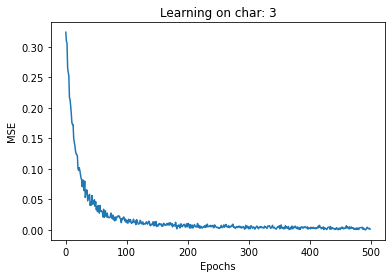

In [10]:
img_RBM = RBM(320, 250) # 320 is the dimension of an (20x16) image flattened

inputs = []
for i in range(35):
    inputs.append(selected_digits[0][i].flatten())
inputs = np.array(inputs)

errors,_ = img_RBM.train_RBM(inputs, 500, 0.01, 6)

plt.plot(errors)
plt.title("Learning on char: 3")
plt.xlabel('Epochs')
plt.ylabel('MSE')

In [11]:
selected_digits.shape

(4, 39)

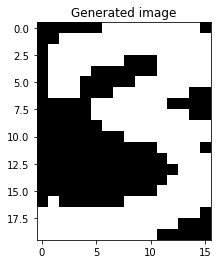

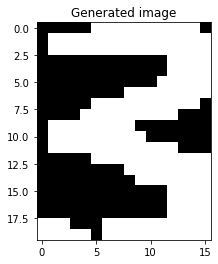

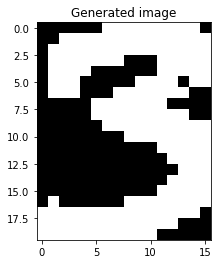

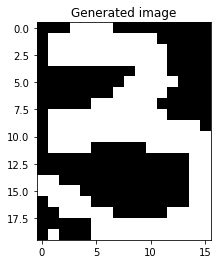

In [12]:
img_RBM.generer_image_RBM(100, 4);

In [19]:
class DBN:
    def __init__(self, nb_layers, shapes_list, W=None, a=None, b=None, var=0.1):
        """
        Used to define a DBN.

        Attributes
        ----------
        nb_layers : int
            an int defining the number of layers in the DBN
        shapes_list : a list of integers 
            contains a sequence of the size of the hidden units, should contain (nb_layers + 1) elements

        """
        self.layers = []
        for i in range(nb_layers):

            # Define the shapes of the hidden units for the RBM
            in_shape = shapes_list[i]
            out_shape = shapes_list[i+1]

            # Define an RBM
            rbm1 = RBM(in_shape,out_shape,W,a,b,var)

            # Append the RBM to our structure
            self.layers.append(rbm1)

        return
        
    def train_DBN(self, X_input, epochs=10, learning_rate=0.01, batch_size=1, vis = False):

        # Looping through the RBM layers and training each of them in a greedy layer wise procedure
        Current_input = X_input.copy()

        for i in range(len(self.layers)):
            current_rbm = self.layers[i]
            
            errors, current_rbm = current_rbm.train_RBM(Current_input,epochs,learning_rate,batch_size,vis)
            # Create the hidden dataset to train the next layer
            _, Hidden_input = current_rbm.entree_sortie_RBM(Current_input)
            Current_input = Hidden_input
            
        
        return self
    
    def generer_image_DBN(self, n_iter_gibbs, n_images, vis=True):

        # Do Gibbs sampling on the top layer:
    
        rbm_last = self.layers[-1]
        outputs = []
        for i in range(n_images):

            v_0 = np.random.binomial(1, np.random.rand(1, rbm_last.in_shape))
            v_0d = v_0.copy()
            for iter in range(n_iter_gibbs):
                _, h_0d = rbm_last.entree_sortie_RBM(v_0d)
                _, v_0d = rbm_last.sortie_entree_RBM(h_0d)

            # Generation by passing v_0d down the remaining layers
            for i in range(len(self.layers) - 2 , -1, -1):
                _, v_0d = self.layers[i].sortie_entree_RBM(v_0d)
            outputs.append(v_0d.reshape(20,16))

            if vis:
                plt.figure()
                plt.imshow(outputs[-1], cmap='gray')
                plt.title("Generated image")
                plt.show()
        return np.array(outputs)

            




            

In [20]:
shapes_list1 = [320, 150, 200, 250]
dbn1 = DBN(nb_layers = 3, shapes_list = shapes_list1)
inputs = []
for i in range(35):
    inputs.append(selected_digits[1][i].flatten())
inputs = np.array(inputs)

dbn1 = dbn1.train_DBN(inputs, 500, 0.01, 6)

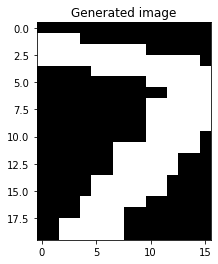

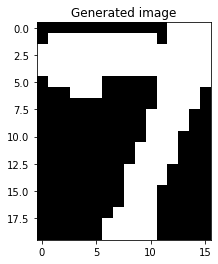

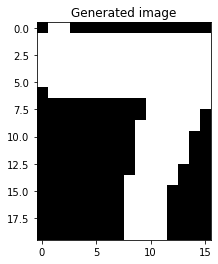

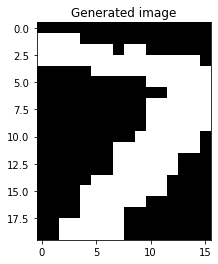

In [21]:
gen_array = dbn1.generer_image_DBN(100, 4)

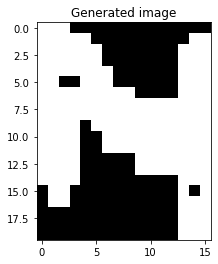

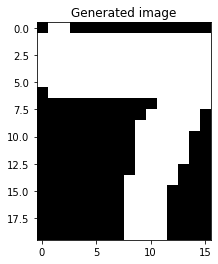

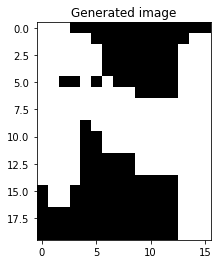

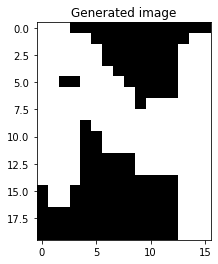

In [22]:
# Let's compare this with the RBM used to generate the digit 7
errors,_ = img_RBM.train_RBM(inputs, 500, 0.01, 6)
img_RBM.generer_image_RBM(100, 4);

We can see that the DBN outperforms the RBM in generating the digit 7

In [23]:
# DNN

def calcul_softmax(rbm : RBM, X_input):
    output = np.dot(X_input, rbm.W) + rbm.b
    num =  np.exp(output - np.max(output))
    den = num.sum(axis = 1).reshape(-1,1)
    return num / den


class DNN:
    def __init__(self, nb_layers, shapes_list, W=None, a=None, b=None, var=0.1):
        """
        Used to define a DBN.

        Attributes
        ----------
        nb_layers : int
            an int defining the number of layers in the DBN, the last layer should be used for classification
        shapes_list : a list of integers 
            contains a sequence of the size of the hidden units, should contain (nb_layers + 1) elements

        """
        # Define a DBN with nb_layers - 1

        dbn1 = DBN(nb_layers-1,shapes_list[:-1])

        self.dbn = dbn1
        self.class_layer = RBM(shapes_list[-2],shapes_list[-1])

        # Add a classification layer

        return
    
    def pretrain_DNN(self, X_input, epochs=10, learning_rate=0.01, batch_size=1, vis = False):

        self.dbn = self.dbn.train_DBN(X_input, epochs, learning_rate, batch_size, vis = False)

        return self
    
    def entree_sortie_reseau(self, X_input):

        list_outputs = []
        list_outputs.append(X_input)

        Current_input = X_input.copy()

        # Loop through the RBM layers of the DBN and append each output to the list
        for i in range(len(self.dbn.layers)):
            Current_rbm = self.dbn.layers[i]
            Current_input,_  = Current_rbm.entree_sortie_RBM(Current_input)
            list_outputs.append(Current_input)

        # Calculate the output of the softmax
        output_classes = calcul_softmax(self.class_layer,Current_input)
        list_outputs.append(output_classes)

        return list_outputs
    
    def retropropagation(self, X_input, labels_input, epochs = 10, learning_rate = 0.1, batch_size = 64, vis = False):
        cross_entropy = []
        for i in range(epochs):
            for bat in range(0, X_input.shape[0], batch_size):
                X_bat = X_input[bat:min(bat + batch_size, X_input.shape[0])]
                labels_bat = labels_input[bat:min(bat + batch_size, X_input.shape[0])]

                # Calculate the forward pass of the network
                list_outputs = self.entree_sortie_reseau(X_bat)

                # Backpropagating through the last layer
                
                del_zo = list_outputs[-1] - labels_bat # del(loss) / del(z) , zo is right before the activation function of the output layer
                del_wo  = np.dot(list_outputs[-2].T,del_zo) / X_bat.shape[0]
                del_bo = np.mean(del_zo)
                
                
                del_activl = np.dot(del_zo, self.class_layer.W.T) # derivative of the loss with respect to the output of the activation layer L

                # Parameters update
                self.class_layer.W -= learning_rate * del_wo
                self.class_layer.b -= learning_rate * del_bo

                # Backpropagation through the remaining layers
                for i in range(len(self.dbn.layers) , 0, -1):

                    # Backpropagation
                    sigmoid_der = list_outputs[i] * (1 - list_outputs[i]) # if sigm(z) = y , then deriv(sigm(z)) = y(1-y)
                    del_zl = del_activl * sigmoid_der
                    del_wl = np.dot(list_outputs[i-1].T,del_zl) / X_bat.shape[0]
                    del_bl = np.mean(del_zl)

                     

                    
                    del_activl = np.dot(del_zl, self.dbn.layers[i-1].W.T)

                    # Parameter update
                    self.dbn.layers[i-1].W -= learning_rate * del_wl
                    self.dbn.layers[i-1].b -= learning_rate * del_bl
                            
            
            
            outputs_full = self.entree_sortie_reseau(X_input)[-1]
            loss = - labels_input * np.log(outputs_full)
            loss = loss.sum()
            cross_entropy.append(loss)
            
        if vis:
            plt.figure(figsize=(15, 10))
            plt.plot(range(epochs), cross_entropy)
            plt.legend(['Cross Entropy'])
            plt.title("Evolution of the cross entropy loss")
            plt.xlabel("iterations")
            plt.ylabel('Cross Entropy')
            plt.show()
        return self

    def test_DNN(self,X_test,y_test):
        y_pred = self.entree_sortie_reseau(X_test)[-1]
        loss = - y_test * np.log(y_pred)
        loss = loss.sum()
        accuracy = accuracy_score(y_pred.argmax(axis=1),y_test.argmax(axis=1))
        print("Loss : {} ".format(loss))
        print("Accuracy: {}".format(accuracy))
        return loss

            

In [24]:
y_train_ohe = to_categorical(y_train, 10)
y_test_ohe = to_categorical(y_test, 10)

In [25]:
# Quick test

X_train_subset = X_train[:2000]
y_train_subset = y_train_ohe[:2000]

X_train_input = X_train_subset.reshape(X_train_subset.shape[0],-1)
shapes_list1=[784, 150, 10]
dnn1 = DNN(nb_layers=2,shapes_list=shapes_list1)
dnn1 = dnn1.pretrain_DNN(X_train_input,epochs=100,batch_size=64)

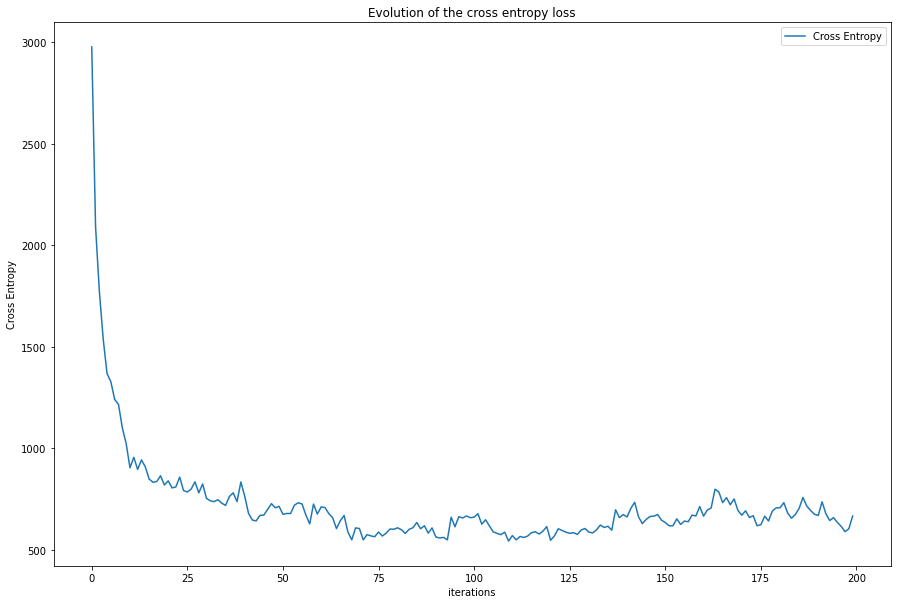

In [26]:
dnn1 = DNN(nb_layers=2,shapes_list=shapes_list1)
dnn1 = dnn1.retropropagation(X_train_input,y_train_subset,epochs=200,learning_rate = 0.1,batch_size=64, vis=True)

In [27]:
dnn1.test_DNN(X_test.reshape(X_test.shape[0],-1),y_test_ohe);

Loss : 5400.172300835134 
Accuracy: 0.8375
